In [3]:
"""
Code to test the convergence consistency of QNADE system. 
"""

"""IMPORTS"""
import math
import time
import torch
import autograd_hacks
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def calculate_epsilons(model, s, psi_omega, B, J):
        """
        Calculates the E_loc(s) for all sampled states.
        epsilon(s) = sum(s_i * s_i+1) + B/psi_s * sum(psi_s_prime)

        Args: 
            model: QNADE model 
            s: sampled states matrix
            psi_omega: np list of wavefunction coefficients    
            B: int, sigma_x activation
            J: int, sigma_z activation 

        Returns: 
            epsilon: double, epsilon contribution for the given state 
        """
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        N = len(s[0])
        
        z_term = torch.zeros([len(s)]).to(device)

        # sum of the wavefunction coefficients resulting from sigma_x acting on each qubit (per sample)
        psi_s_prime_sum = torch.zeros([len(s)]).to(device)

        for i in range(N):
            
            if i == N-1:
                z_term += s[:,0]*s[:,i]
            else:
                z_term += s[:,i]*s[:,i+1]

            # calculate the sum of psi_s_prime for the sigma_x term
            s_prime = s.clone()
            s_prime[:,i] = -1*s_prime[:,i]
            psi_s_prime,_,_ = model(x=s_prime, requires_grad=False) 
            psi_s_prime_sum += psi_s_prime
        
        x_term = psi_s_prime_sum/psi_omega

        epsilons = -(J*z_term + B*x_term)
        
        return epsilons

def calculate_expected_e(n, g):

  J = 1
  B = g

  #Initialize operators and Identity matrix
  s_z = np.array([[1,0],[0,-1]])
  s_x = np.array([[0,1],[1,0]])
  I = np.array([[1,0],[0,1]])

  #Calculate and print energies for n qubits
  #print("\nQubits:", n)
  H = np.zeros((2**n,2**n))
  H_ising = np.zeros((2**n,2**n))
  H_tf = np.zeros((2**n,2**n))

  #Generate and add Ising components to Hamiltonian
  for i in range(0,n):
      if i == 0 or i == n-1:
          ising_comp = s_z
      else:
          ising_comp = I
      for j in range(0,n-1):
          if j == i or j == i-1:
              ising_comp = np.kron(ising_comp, s_z)
          else:
              ising_comp = np.kron(ising_comp, I)
      H_ising += ising_comp

  #Generate and add transverse components to Hamiltonian
  for i in range(0,n):
      if i == 0:
          trans_comp = s_x
      else:
          trans_comp = I
      for j in range(0,n-1):
          if j == i-1:
              trans_comp = np.kron(trans_comp, s_x)
          else:
              trans_comp = np.kron(trans_comp, I)
      H_tf += trans_comp
      
  H = -(J*H_ising + B*H_tf)

  return min(np.linalg.eigvals(H))

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created Jan 28 2021

@authors: Alex Lidiak, Caleb Sanders
This model takes as input a FFNN (N inputs, 2 outputs) and converts it into a 
QNADE model. 

The QNADE class performs the autoregressive sample generation, conditional 
wavefunction calculation, and gradient accumulation needed to optimize a 
FFNN to produce the ground state energy of an arbitrary many-body system.  
"""

class QNADE(nn.Module): # takes a FFNN model as input
            
    def __init__(self, model): 
        super(QNADE, self).__init__()
        
        self.model = model
        self.D = self.model[0].in_features # input layer size
        self.M = self.model[-2].out_features # output layer size
        self.evals = [0,1]
            
    def forward(self, N_samples=None, x=None, requires_grad=True):

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if N_samples is None and x is None: 
            raise ValueError('Must enter samples or the number of samples to' \
                             ' be generated')
            
        # if not sampling, just calculating wavefunction
        if N_samples is None and x is not None: 
            N_samples, need_samples = x.shape[0], False

        # if sampling and calculating wavefunction
        if N_samples is not None and x is None: 
            need_samples = True
            x = torch.zeros([N_samples,self.D],dtype=torch.float).to(device)
            
        # the full wavefunction is a product of the conditionals
        WAV = torch.ones([N_samples]).to(device) 
        order = np.arange(0,self.D) # sequential autoregressive ordering 
        
        # for gradient tracking 
        params = list(self.parameters()) 
        grads_per_param = [] 
        
        for d in range(self.D):
                
            # mask enforces the autoregressive property
            mask=torch.zeros_like(x)
            mask[:,order[0:(d)]] = 1 

            # add autograd hooks for per-sample gradient calculation 
            if not hasattr(self.model,'autograd_hacks_hooks'):             
              autograd_hacks.add_hooks(self.model)
            
            # L2 normalization of masked output
            out = F.normalize(self.model(mask*x), 2)
            
            # 'psi_pos' is positive bits, 'psi_neg' is negative bits 
            psi_pos = out[:,0].squeeze()
            psi_neg = out[:,1].squeeze()

            if need_samples == True:
                
              # sampling routine according to psi**2:
              # convert bit values from 0 to -1
              m = torch.distributions.Bernoulli(psi_pos**2).sample()
              m = torch.where(m == 0, 
                              torch.tensor(-1).to(device), 
                              torch.tensor(1).to(device)) 
              
              # update sample tensor
              x[:,d] = m

              # Accumulate PSI based on which state (s) was sampled
              selected_wavs = torch.where(x[:,d] > 0, psi_pos, psi_neg) 
              WAV = WAV*selected_wavs

            else: 

              # if not sampling, m is a list of bits in column d 
              m = x[:,d]

              # Accumulate PPSI based on which state (s) was sampled
              selected_wavs = torch.where(m > 0, psi_pos, psi_neg) 
              WAV = WAV*selected_wavs

            if requires_grad == True:

              # eval_grads stores backpropagation values for out1 and out2.
              # eval_grads[0] are the out1 grads for all samples (per param), 
              # eval_grads[1] are the out2 grads for all samples (per param). 
              eval_grads = [ [[]]*len(params) for outputs in range(len(self.evals)) ]

              # Store the per-output grads in eval_grads
              for output in range(len(self.evals)):

                # backpropagate the current output (out1 or out2)
                out[:,output].mean(0).backward(retain_graph=True)

                # compute gradients for all samples 
                autograd_hacks.compute_grad1(self.model)
                autograd_hacks.clear_backprops(self.model)

                # store the calculated gradients for all samples 
                for param in range(len(params)):
                  eval_grads[output][param] = params[param].grad1

              # allocate space for gradient accumulation 
              if d == 0:
                for param in range(len(params)):
                  grads_per_param.append(torch.zeros_like(eval_grads[0][param]))
              
              # accumulate gradients per parameter based on sampled bits
              for param in range(len(params)):

                # reshape m and wavs so they can be accumulated/divided properly 
                reshaped_m = m.reshape(m.shape + (1,)*(grads_per_param[param].ndim-1))
                reshaped_wavs = selected_wavs.reshape(selected_wavs.shape + (1,)*(grads_per_param[param].ndim-1))

                # select the proper gradient to accumulate based on m 
                grads_per_param[param][:] += torch.where(reshaped_m[:] > 0, 
                                                         eval_grads[0][param][:]/reshaped_wavs[:], 
                                                         eval_grads[1][param][:]/reshaped_wavs[:])

        return WAV.detach(), x.detach(), grads_per_param

In [6]:
"""OPTIMIZATION"""

def train(g, num_qubits, learning_rate):

  # define device 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  energies_per_g = []

  # number of qubits
  L = num_qubits
  H = 2*L

  J = 1 #sigma_z activation
  B = g #sigma_x activation

  # initialize network and model, put network on device 
  network = nn.Sequential(nn.Linear(L,H), 
                          nn.Tanh(),
                          nn.Linear(H, 2),  
                          nn.Tanh())
  network.to(device) 
  model = QNADE(network)
  params = list(model.parameters())

  # Training hyperparameters 
  iters = 100
  batch_size = 10000
  lr = learning_rate

  # initialize optimizer 
  optimizer = torch.optim.Adam(params=network.parameters(), lr=lr)
  optimizer.zero_grad()

  # training loop 
  energies = []
  for iter in range(iters):

    #if iter%10 == 0: print("iter: {}".format(iter))

    # generate data 
    psi_omega, samples, grads_per_param = model(N_samples=batch_size)

    # calculate local energies 
    epsilons = calculate_epsilons(model, samples, psi_omega, B, J).to(device)

    # E is an average of local energies
    E = epsilons.mean()
    energies.append(E)
    epsilons -= E 
    
    # calculate O_k for a given parameter and number of samples 
    for param in range(len(params)):

      # define O_k for a set of parameters 
      O_k = grads_per_param[param].detach()

      # weight O_k according to epsilons 
      O_k *= epsilons.reshape(epsilons.shape + (1,)*(O_k.ndim-1))

      # e_grad is an average of all O_k_s 
      e_grad = torch.mean(O_k, 0, keepdim=True).squeeze()

      # update network parameter matrix with energy gradient  
      with torch.no_grad():
        params[param].grad.copy_(e_grad)

    #optimize network based on e_grad 
    optimizer.step() 

  final_energy = min(energies)

  energies_per_g.append(float(final_energy))

  return min(energies_per_g)

In [9]:
"""GENERATE DATA FOR NUM_TRIALS"""

B_val = 1
lr = 0.01
L = 2
num_trials = 5

E = calculate_expected_e(L, B_val)
print(E)

E_train = []
for trial in range(num_trials):
  print(trial)
  E_train.append(train(B_val, L, lr))

print(E_train) 

-2.82842712474619
0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


1
2
3
4
[-2.824357032775879, -2.5565147399902344, -2.4771957397460938, -2.828566074371338, -2.828655481338501]


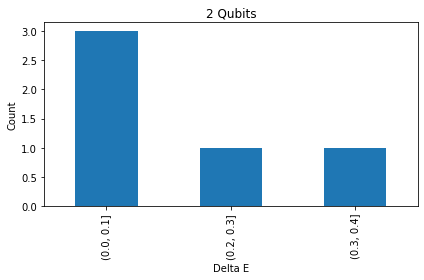

In [10]:
"""BIN AND PLOT DATA"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

delta_E = [abs(E - calc_E) for calc_E in E_train]

cut_bins = np.linspace(0,5,51) #needs to be adjusted depending on dataset generated  
df = pd.DataFrame(delta_E, columns=['delta E'])
df['bin'] = pd.cut(df['delta E'], bins=cut_bins).astype(str)
df2 = df.groupby('bin').bin.count()

ax = df2.plot(kind='bar')
ax.set_xlabel("Delta E")
ax.set_ylabel("Count")
ax.set_title("{} Qubits".format(L))
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("plot")